In [1]:
import numpy as np
import cv2
import os
from utils import cv2_imshow

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
img1, img2, img3 = [
    cv2.imread(os.path.join("building", f"img-0{i}.jpg")) for i in range(3)
]

<IPython.core.display.Javascript object>

In [4]:
# Define colors for 8 lines
colors = [
    (255, 0, 0),
    (255, 128, 0),
    (255, 255, 0),
    (64, 255, 0),
    (0, 255, 255),
    (0, 0, 255),
    (255, 0, 255),
    (255, 255, 255),
]

<IPython.core.display.Javascript object>

In [15]:
points1 = [
    (413, 110),
    (411, 195),
    (150, 246),
    (143, 378),
    (447, 211),
    (444, 275),
    (403, 144),
    (187, 232),
]
points2 = [
    (697, 254),
    (700, 304),
    (456, 237),
    (460, 400),
    (748, 333),
    (752, 365),
    (683, 269),
    (363, 195),
]
points3 = [
    (647, 284),
    (648, 327),
    (571, 257),
    (569, 404),
    (676, 353),
    (678, 380),
    (637, 296),
    (489, 215),
]

<IPython.core.display.Javascript object>

In [6]:
images = [img1, img2, img3]
points = [points1, points2, points3]

<IPython.core.display.Javascript object>

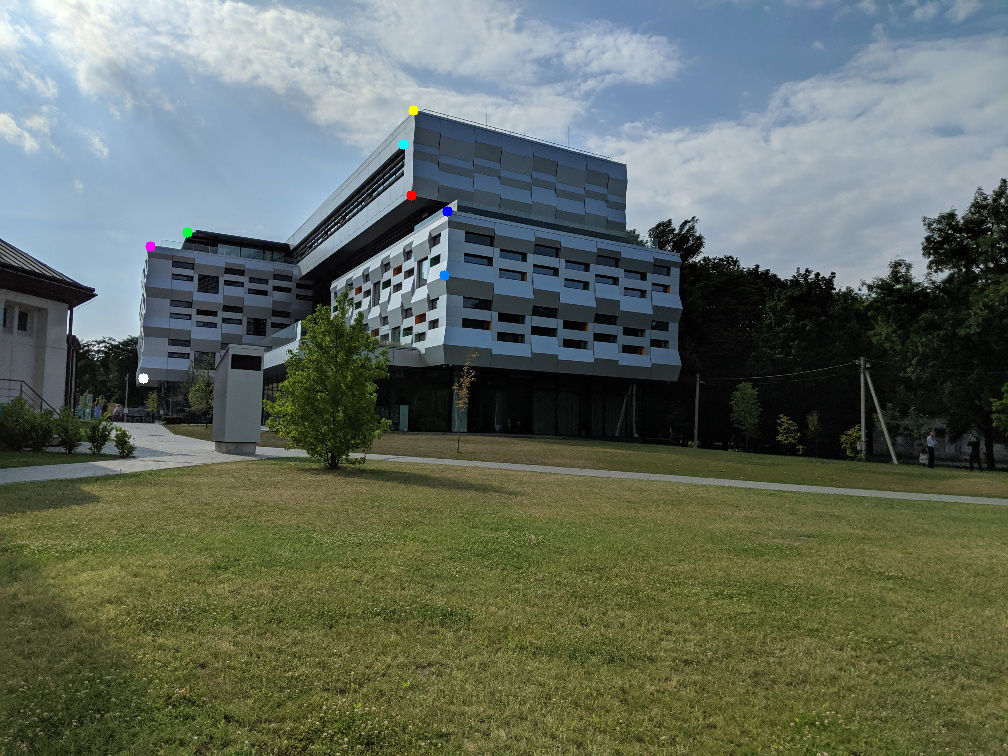

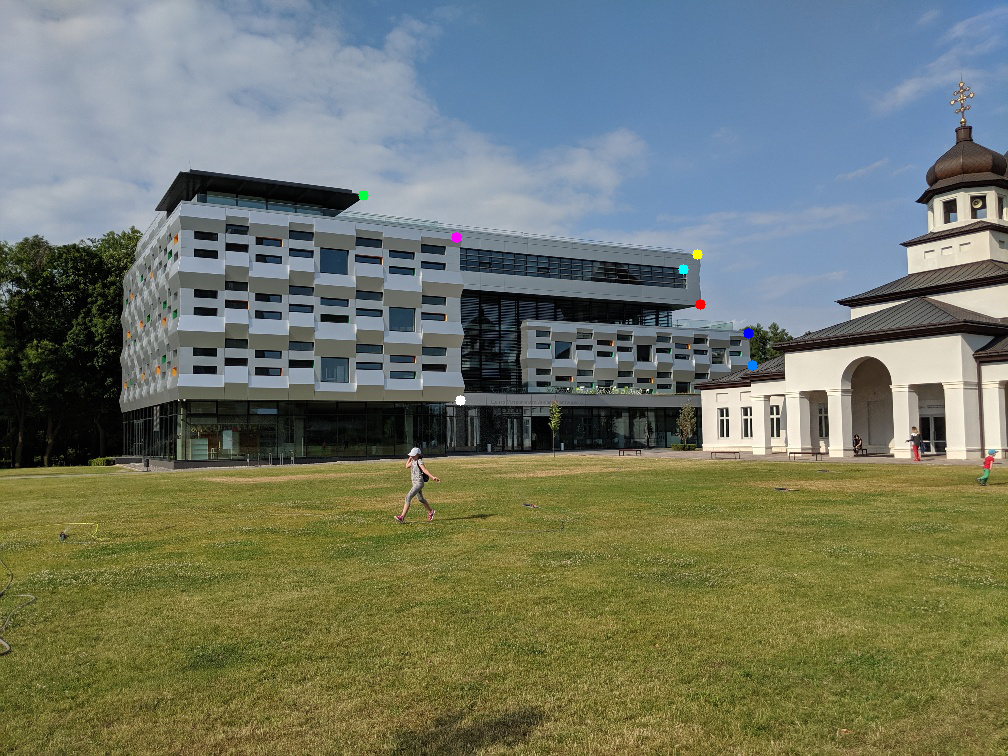

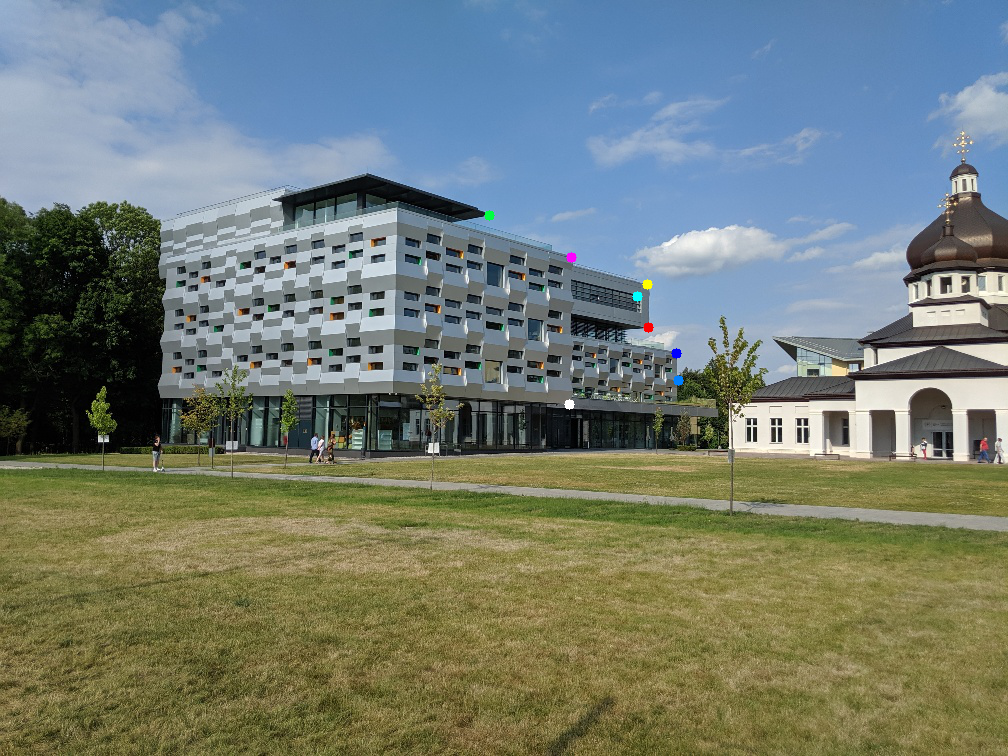

<IPython.core.display.Javascript object>

In [7]:
for image, image_points in zip(images, points):
    image_copy = image.copy()
    for point, color in zip(image_points, colors):
        cv2.circle(image_copy, point, 5, color, -1)

    cv2_imshow(image_copy)

In [8]:
def normalize2dpts(pts):
    pts = np.r_[pts.T, np.ones((1, len(pts)))]
    finiteind = np.nonzero(abs(pts[2, :]) > np.spacing(1))

    if len(finiteind[0]) != pts.shape[1]:
        print("Some points are at infinity")

    dist = []
    for i in finiteind:
        pts[0, i] = pts[0, i] / pts[2, i]
        pts[1, i] = pts[1, i] / pts[2, i]
        pts[2, i] = 1

        c = np.mean(pts[0:2, i].T, axis=0).T

        newp1 = pts[0, i] - c[0]
        newp2 = pts[1, i] - c[1]

        dist.append(np.sqrt(newp1 ** 2 + newp2 ** 2))
    dist = np.array(dist)
    meandist = np.mean(dist)

    scale = np.sqrt(2) / meandist

    T = np.array([[scale, 0, -scale * c[0]], [0, scale, -scale * c[1]], [0, 0, 1]])

    newpts = T.dot(pts)

    return [newpts, T]

<IPython.core.display.Javascript object>

In [9]:
def get_fundamental(pts1, pts2):
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    n = pts1.shape[0]
    assert pts1.shape == pts2.shape, "Points shapes must be equal"

    x1, T1 = normalize2dpts(pts1)
    x2, T2 = normalize2dpts(pts2)

    A = np.c_[
        x2[0] * x1[0],
        x2[0] * x1[1],
        x2[0],
        x2[1] * x1[0],
        x2[1] * x1[1],
        x2[1],
        x1[0],
        x1[1],
        np.ones((n, 1)),
    ]

    U, S, V = np.linalg.svd(A)
    V = V.conj().T
    F = V[:, n].reshape(3, 3).copy()

    (U, D, V) = np.linalg.svd(F)
    F = np.dot(np.dot(U, np.diag([D[0], D[1], 0])), V)

    F = np.dot(np.dot(T2.T, F), T1)
    return F

<IPython.core.display.Javascript object>

In [10]:
F1 = get_fundamental(points1, points2)

F2 = get_fundamental(points2, points3)

<IPython.core.display.Javascript object>

In [11]:
def draw_epipolar_lines(image, points, F, colors):
    h, w, _ = image.shape

    image = image.copy()
    for point, color in zip(points, colors):
        p = np.append(point, 1)
        p = F.T.dot(p)

        lp1 = (0, int(-p[2] / p[1]))
        lp2 = (w, int(-(p[0] * w + p[2]) / p[1]))
        cv2.line(image, lp1, lp2, color, 1)

    return image

<IPython.core.display.Javascript object>

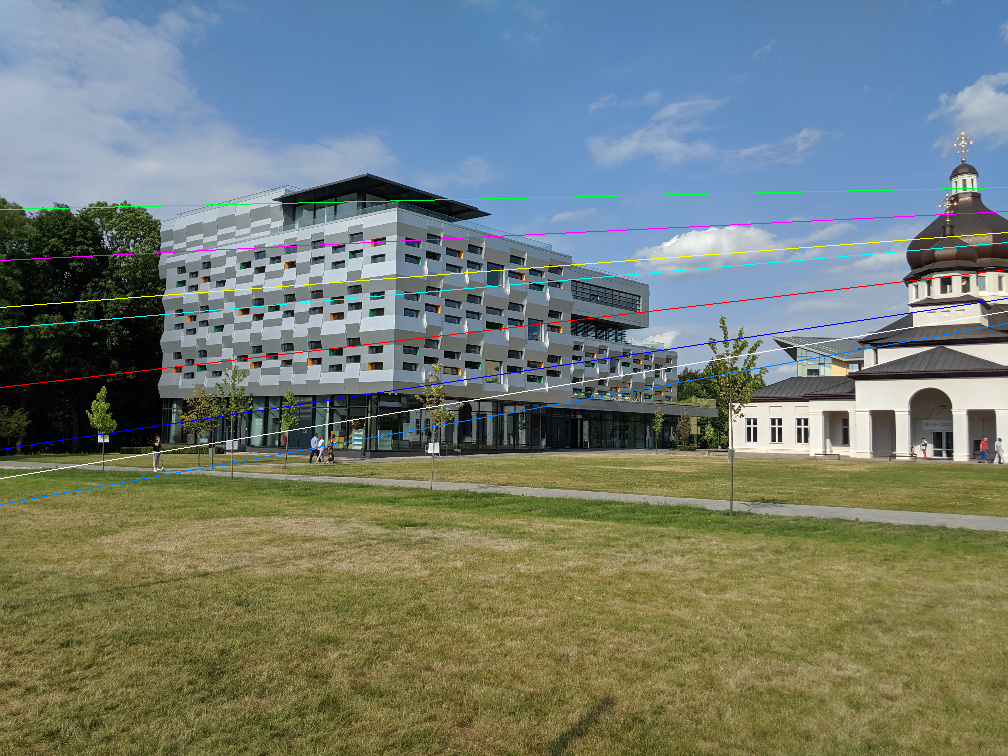

<IPython.core.display.Javascript object>

In [12]:
cv2_imshow(draw_epipolar_lines(img3, points3, F2, colors))

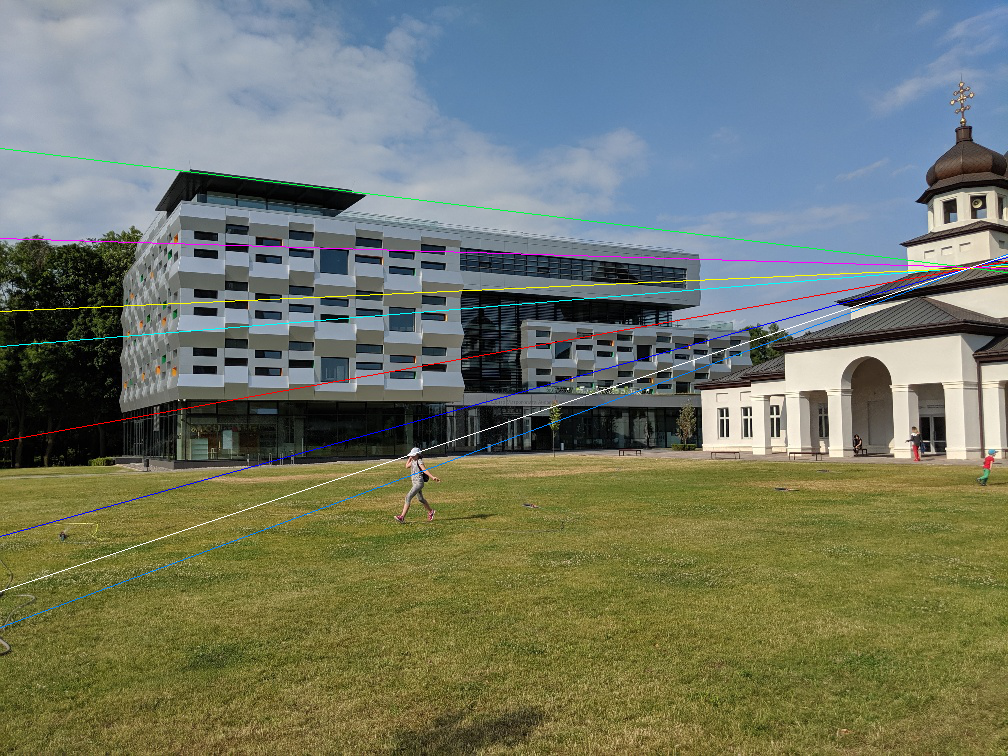

<IPython.core.display.Javascript object>

In [13]:
cv2_imshow(draw_epipolar_lines(img2, points2, F2.T, colors))

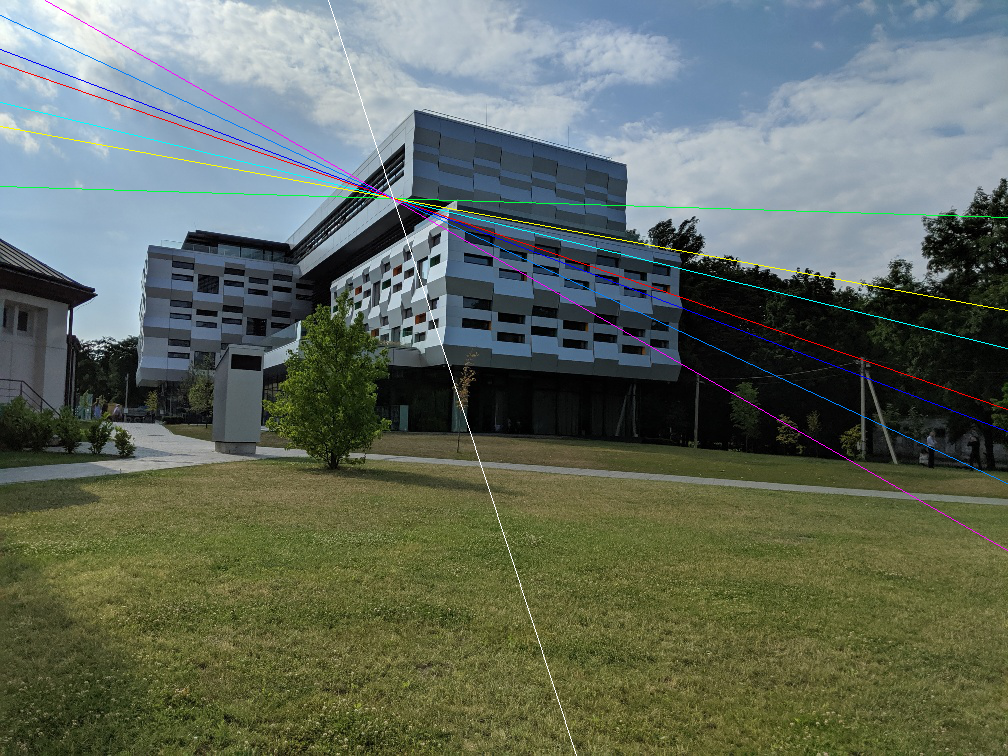

<IPython.core.display.Javascript object>

In [14]:
cv2_imshow(draw_epipolar_lines(img1, points1, F1.T, colors))

### There may be some error when calculating points1 fundamental matrix